## Models, simulation, and degrees of belief

One view of knowledge is that the mind maintains working models of parts of the world. ‘Model’ in the sense that it captures some of the structure in the world, but not all (and what it captures need not be exactly what is in the world—just what is useful). ‘Working’ in the sense that it can be used to simulate this part of the world, imagining what will follow from different initial conditions. As an example take the Plinko machine: a box with uniformly spaced pegs, with bins at the bottom. Into this box we can drop marbles.
The plinko machine is a ‘working model’ for many physical processes in which many small perturbations accumulate—for instance a leaf falling from a tree. It is an approximation to these systems because we use a discrete grid (the pegs) and discrete bins. Yet it is useful as a model: for instance, we can ask where we expect a marble to end up depending on where we drop it in, by running the machine several times—simulating the outcome.

Imagine that someone has dropped a marble into the plinko machine; before looking at the outcome, you can probably report how much you believe that the ball has landed in each possible bin. Indeed, if you run the plinko machine many times, you will see a shape emerge in the bins. The number of balls in a bin gives you some idea how much you should expect a new marble to end up there. This ‘shape of expected outcomes’ can be formalized as a probability distribution (described below). Indeed, there is an intimate connection between simulation, expectation or belief, and probability, which we explore in the rest of this section.

There is one more thing to note about our Plinko machine above: we are using a computer program to simulate the simulation. Computers can be seen as universal simulators. How can we, clearly and precisely, describe the simulation we want a computer to do?

## Building Generative Models

We wish to describe in formal terms how to generate states of the world. That is, we wish to describe the causal process, or steps that unfold, leading to some potentially observable states. The key idea of this section is that these generative processes can be described as computations—computations that involve random choices to capture uncertainty about the process.

Programming languages are formal systems for describing what (deterministic) computation a computer should do. Modern programming languages offer a wide variety of different ways to describe computation; each makes some processes simple to describe and others more complex. However, a key tenet of computer science is that all of these languages have the same fundamental power: any computation that can be described with one programming language can be described by another. (More technically this Church-Turing thesis posits that many specific computational systems capture the set of all effectively computable procedures. These are called universal systems.)

The original book uses JavaScript language for all examples. We will translate the code to Julia using Gen library that extends it with pieces needed to describe probabilistic computation. The key idea is that we have primitive operations that describe not only deterministic functions (like and) but stochastic operations. For example, we wil use Bernoulli distribution:

In [28]:
using Gen: bernoulli
p=0.5
bernoulli(p)

true

Run this program a few times. You will get back a different sample on each execution. Also, notice the parentheses after Bernoulli, you should enter "p" parameter.

If you run the program many times, and collect the values in a histogram, you can see what a typical sample looks like: (edited) 


In [29]:
N=1000
ys=[bernoulli(p) for _ in 1:N]



1000-element Vector{Bool}:
 0
 1
 1
 1
 0
 0
 0
 0
 0
 1
 0
 1
 1
 ⋮
 0
 1
 1
 0
 0
 0
 1
 1
 1
 1
 0
 1

we will now create a wrapper function for bar visualization

In [24]:
using StatsPlots, StatsBase
function viz(values,title="",xlabel="",ylabel="Frequency")
    datamap = countmap(values)
    s = sort(collect(keys(datamap)))
    bar((x -> datamap[x]/length(values)).(s),xticks=(1:length(s), s),title=title,xlabel=xlabel,ylabel=ylabel)
end

function groupedviz(values,names,cats,num_groups,title="",xlabel="",ylabel="Frequency")
    datamap1 = countmap(y1)
    datamap2 = countmap(y2)
    datamap3 = countmap(y3)
    N=0
    counts=zeros(num_groups,2)
    i::Int32=1
    for value in values
        datamap=countmap(value)
        N=length(value)
        for item in datamap
            if item.first == cats[:1]
            counts[i,1]=item.second/N
            else
            counts[i,2]=item.second/N
            end
        end
        i=i+1
    end
    ctg = repeat(cats, inner = num_groups)    
    groupedbar(names, counts, group = ctg, xlabel = xlabel, ylabel = ylabel,
            title =title, bar_width = 0.67,
            lw = 0, framestyle = :box)
end

groupedviz (generic function with 4 methods)

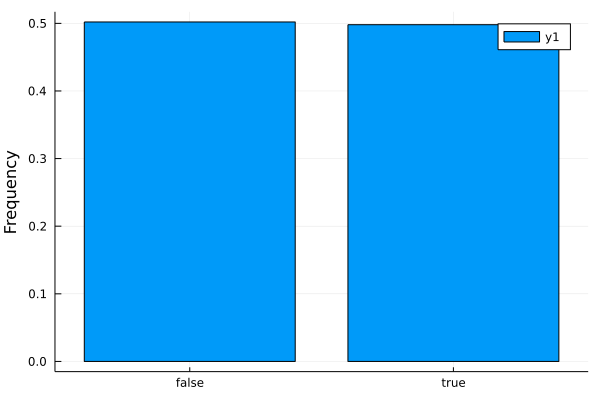

In [30]:
viz(ys)

Here we want to sample 1000 Bernoulli random variables.
We have used the `bar` function to visualize the results of calling the `bernoulli` function 1000 times. As you can see, the result is an approximately uniform distribution over `true` and `false`.

Using `bernoulli`  distribution we can construct more complex expressions that describe more complicated sampling processes. For instance here we describe a process that samples a number adding up several samples (as we can see Julia translated boolean to 0,1)

In [5]:
bernoulli(p)+bernoulli(p)+bernoulli(p)

3

What if we want to invoke this sampling process multiple times? We would like to construct a stochastic function that adds three random numbers each time it is called. We can use `function` to construct such complex stochastic functions from the primitive ones.

In [6]:
function sumFlips() 
    bernoulli(p)+bernoulli(p)+bernoulli(p)
end

sumFlips (generic function with 1 method)

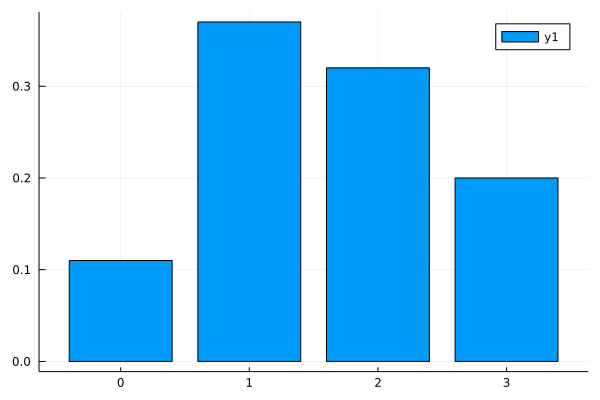

In [7]:
N=100
ys=[sumFlips() for _ in 1:N]
viz(ys)

A function expression with an empty argument list, `function() ... end`, is called a thunk: this is a function that takes no input arguments. If we apply a thunk (to no arguments!) we get a return value back. Complex functions can also have arguments. Here is a stochastic function that will only sometimes double its input:

In [8]:
function noisyDouble(x::Number) 
     bernoulli(p) ? x+x : x 
end
noisyDouble(3)

3

By using higher-order functions we can construct and manipulate complex sampling processes. We use the ternary operator `condition ? if-true : if-false` to induce hierarchy. A good example comes from coin flipping…

### Example: Flipping Coins
The following program defines a fair coin, and flips it 20 times:

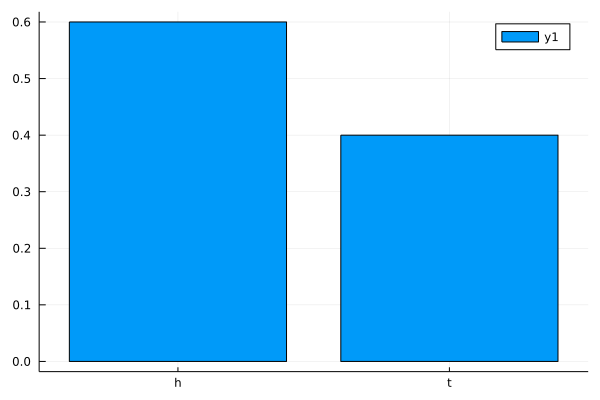

In [9]:
function faircoin()
    bernoulli(p) ? 'h' : 't'
end
N=20
ys=[faircoin() for _ in 1:N ]
viz(ys)

This program defines a “trick” coin that comes up heads most of the time (95%), and flips it 20 times:

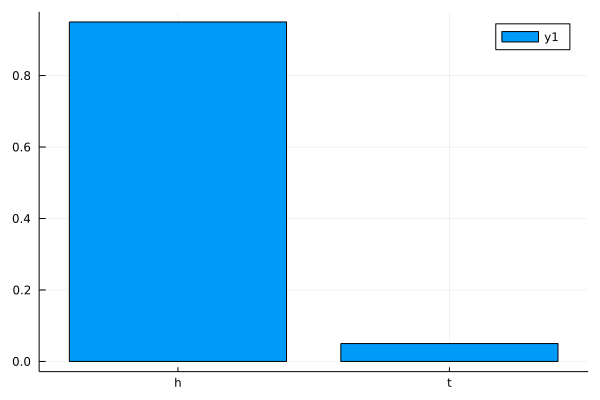

In [10]:
function trickoin()
    bernoulli(0.95) ? 'h' : 't'
end
N=20
ys=[trickoin() for _ in 1:N ]
viz(ys)

The higher-order function `make-coin` takes in a weight and outputs a function (a thunk) describing a coin with that weight. Then we can use `make-coin` to make the coins above, or others.

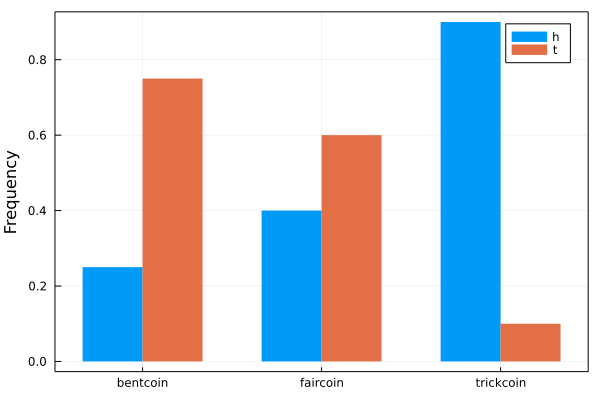

In [32]:
function makecoin(p::Float64)
    function ()
        bernoulli(p) ? 'h' : 't'
    end    
end
faircoin1=makecoin(0.5)
trickcoin1=makecoin(0.95)
bentcoin1=makecoin(0.25)
N=20
counts=zeros(3,2)
y1=[faircoin1()  for _ in 1:N ]
y2=[trickcoin1()  for _ in 1:N ]
y3=[bentcoin1()  for _ in 1:N ]
groupedviz([y1,y2,y3],["faircoin","trickcoin","bentcoin","faircoin","trickcoin","bentcoin"],['h', 't'],3)

We can also define a higher-order function that takes a “coin” and “bends it”:


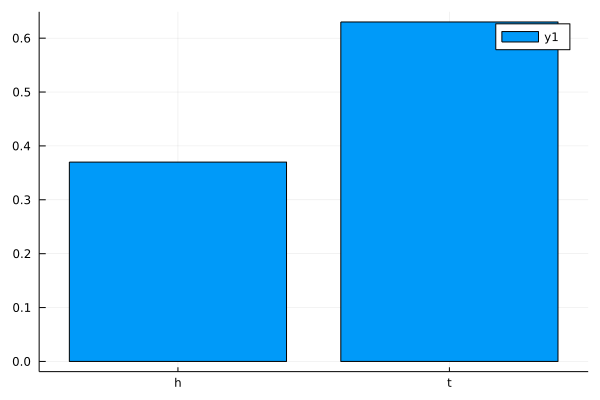

In [12]:
function bend(coin)
    function ()
        coin() == 'h' ? makecoin(0.7)() : makecoin(0.1)()
    end
end
bentcoin2=bend(faircoin1)
N=100
ys=[bentcoin2() for _ in 1:N]
viz(ys)

Make sure you understand how the `bend` function works! Why are there an “extra” pair of parentheses after each `make-coin` statement?

We want to visualize the number of heads we expect to see if we flip a weighted coin (weight = 0.8) 10 times. We’ll repeat this experiment 1000 times and then use `bar` to visualize the results. Try varying the coin weight or the number of repetitions to see how the expected distribution changes.


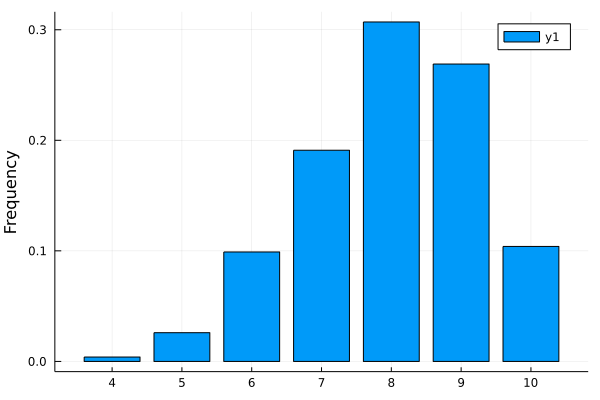

In [33]:
coin=makecoin(0.8)
ys=[sum(map(x -> x == 'h' ? 1 : 0, [coin()  for _ in 1:10])) for _ in 1:1000]
viz(ys)

### Example: Causal Models in Medical Diagnosis
Generative knowledge is often causal knowledge that describes how events or states of the world are related to each other. As an example of how causal knowledge can be encoded in Julia expressions, consider a simplified medical scenario:

In [14]:
lungCancer = bernoulli(0.01)
cold = bernoulli(0.2)
cough = cold || lungCancer

true

This program models the diseases and symptoms of a patient in a doctor’s office. It first specifies the base rates of two diseases the patient could have: lung cancer is rare while a cold is common, and there is an independent chance of having each disease. The program then specifies a process for generating a common symptom of these diseases – an effect with two possible causes: The patient coughs if they have a cold or lung cancer (or both).
Here is a more complex version of this causal model:

In [15]:
lungCancer = bernoulli(0.01)
TB = bernoulli(0.005)
stomachFlu = bernoulli(0.1)
cold = bernoulli(0.2)
other = bernoulli(0.1)

cough = 
    (cold && bernoulli(0.5)) ||
    (lungCancer && bernoulli(0.3)) ||
    (TB && bernoulli(0.7)) ||
    (other && bernoulli(0.01))

fever = 
    (cold && bernoulli(0.3)) ||
    (stomachFlu && bernoulli(0.5)) ||
    (TB && bernoulli(0.1)) ||
    (other && bernoulli(0.01))

chestPain = 
    (lungCancer && bernoulli(0.5)) ||
    (TB && bernoulli(0.5)) ||
    (other && bernoulli(0.01))

shortnessOfBreath = 
    (lungCancer && bernoulli(0.5)) ||
    (TB && bernoulli(0.2)) ||
    (other && bernoulli(0.01))

symptoms = Dict([
  "cough" => cough,
  "fever" => fever,
  "chestPain" => chestPain,
  "shortnessOfBreath" => shortnessOfBreath
])

symptoms

Dict{String, Bool} with 4 entries:
  "cough"             => 0
  "shortnessOfBreath" => 0
  "fever"             => 0
  "chestPain"         => 0

Now there are four possible diseases and four symptoms. Each disease causes a different pattern of symptoms. The causal relations are now probabilistic: Only some patients with a cold have a cough (50%), or a fever (30%). There is also a catch-all disease category “other”, which has a low probability of causing any symptom. Noisy logical functions—functions built from and `(&&)`, or `(||)`, and `bernoulli`—provide a simple but expressive way to describe probabilistic causal dependencies between Boolean (true-false valued) variables.
When you run the above code, the program generates a list of symptoms for a hypothetical patient. Most likely all the symptoms will be false, as (thankfully) each of these diseases is rare. Experiment with running the program multiple times. Now try modifying the statement for one of the diseases, setting it to be true, to simulate only patients known to have that disease. For example, replace `lungCancer = bernouli(0.01)` with  `lungCancer = true`. Run the program several times to observe the characteristic patterns of symptoms for that disease.

### Prediction, Simulation, and Probabilities
Suppose that we flip two fair coins, and return the list of their values:

In [16]:
[bernoulli(0.5),bernoulli(0.5)]

2-element Vector{Bool}:
 0
 1

How can we predict the return value of this program? For instance, how likely is it that we will see `[1, 0]`? A probability is a number between 0 and 1 that expresses the answer to such a question: it is a degree of belief that we will see a given outcome, such as `[1, 0]`. The probability of an event A (such as the above program returning `[1, 0]`) is usually written as: `P(A)`.
A probability distribution is the probability of each possible outcome of an event. For instance, we can examine the probability distribution on values that can be returned by the above program by sampling many times and examining the histogram of return values:

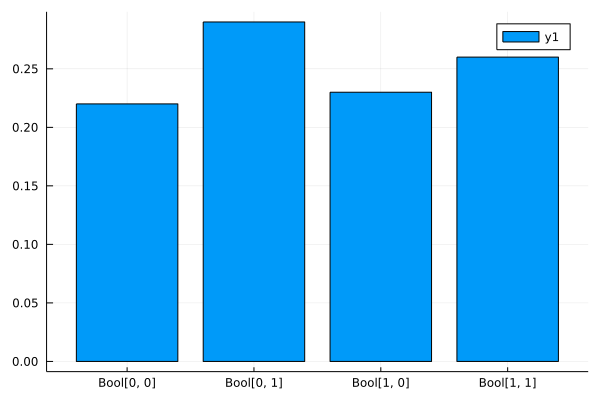

In [17]:
function radomPair()    
    [bernoulli(0.5),bernoulli(0.5)]
    
end
N=100
ys=[radomPair()  for _ in 1:N ]
viz(ys)

We see by examining this histogram that `[1, 0]` comes out about 25% of the time. We may define the probability of a return value to be the fraction of times (in the long run) that this value is returned from evaluating the program – then the probability of `[1, 0]` from the above program is 0.25.

### Distributions in Gen
An important idea is that `bernoulli` can be thought of in two different ways. From one perspective,`bernoulli` is a procedure which returns a sample from a fair coin. That is, it’s a sampler or simulator. As we saw above we can build more complex samplers by building more complex functions. From another perspective, `bernoulli` is itself a characterization of the probability distribution over `true` and `false`. In order to make this view explicit, Gen has a special type of distribution objects. These are objects that can be sampled from using the `simulate` operator, and that can explicitly return the probability of a return value using the `get_score` method. Distributions are made by a family of distribution constructors:


true
-0.6931471805599453


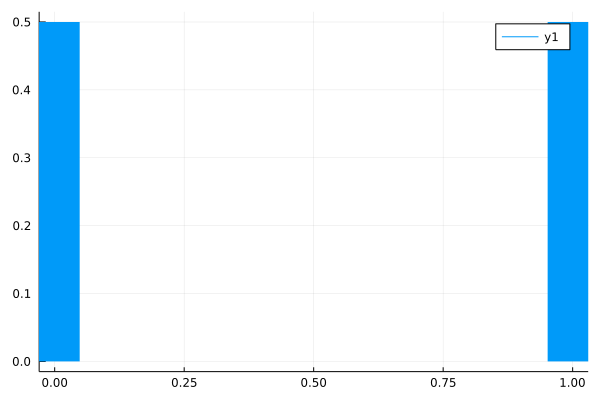

In [18]:
using Distributions, Gen
@gen function foo()
    @trace(bernoulli(0.5), :b)
end
#sample from it with the simulate operator:
trace = simulate(foo, ())
println(trace[:b])
#compute the log-probability of sampled data:
println(Gen.get_score(trace))
#visualize the distribution using julia native Bernoulli sampler:
plot(Bernoulli(0.5), lw=50)

There are many other distribution constructors built into Gen listed [here](https://www.gen.dev/stable/ref/distributions/). For instance the  Normal distribution is a very common distribution over real numbers:

In [19]:
@gen function goo()
    @trace(normal(0, 1) , :g)
end
#sample from it with the simulate operator:
trace = simulate(goo, ())
println(trace[:g])

#can also use the sampling helper (note lower-case name):
print(normal(0,1))

#and build more complex processes!
hoo = () -> normal(0,1) * normal(0,1) 
hoo()


-0.48976735636034874
0.3060681874352719

-0.016463775371952222

???????

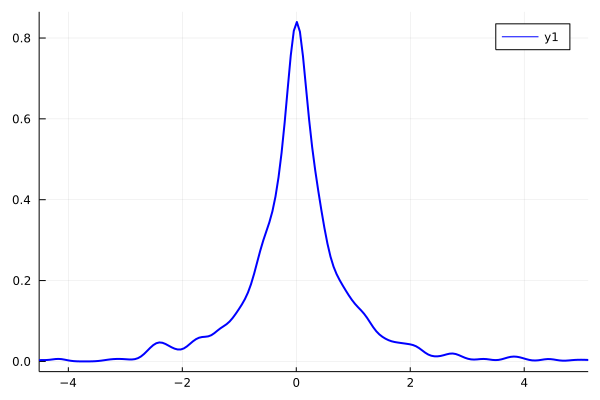

In [20]:
@gen function complexDist()
    a=@trace(normal(0, 1), :a)
    b=@trace(normal(0, 1), :b)
    a*b
end
d=complexDist
values=[d() for _ in 1:1000]

p = plot(values, seriestype = :density, xlim = (minimum(values),maximum(values)), legend = :best, w = 2, c = :blue)


??????

In [21]:
a=bernoulli(0.5)
b=bernoulli(0.5)
c=[a,b]

2-element Vector{Bool}:
 0
 1

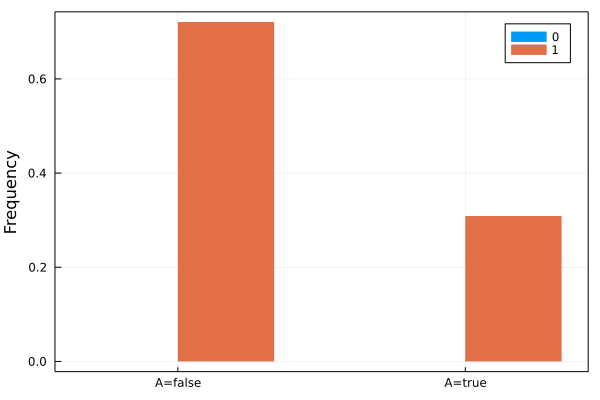

In [31]:
@gen function c()
    a=@trace(bernoulli(0.5), :a)
    b=@trace(bernoulli(a ? 0.3 : 0.7), :b)
    (a,b)
end
values=[c() for _ in 1:1000]
a0=map(x -> string("B = ",x[:2]),filter(x -> x[:1]==0, values))
a1=map(x -> string("B = ",x[:2]),filter(x -> x[:1]==1, values))
groupedviz([a0,a1],["A=false","A=true","A=false","A=true"],[0,1],2)


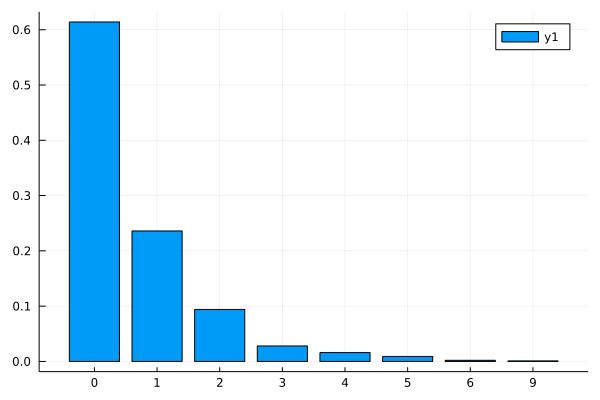

In [23]:
@gen function geo(p)
    bernoulli(p) ? 0 : 1 + geo(p)
end
data=[geo(0.6) for _ in 1:1000]
viz(data)